## Import Packages

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import skimage
from skimage import morphology
from PIL import Image
from moviepy.editor import VideoFileClip

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


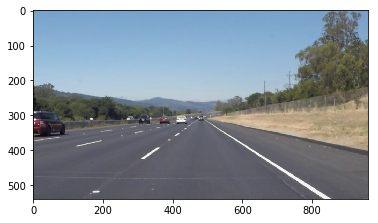

In [2]:
#reading in an image
image = np.asarray(Image.open('test_images/solidWhiteRight.jpg'))

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Helper Functions

In [3]:
def region_of_interest(img, r_coor, c_coor):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    rr, cc = skimage.draw.polygon(r_coor, c_coor)
    mask[rr, cc] = 1
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    right_x = []
    right_y = [] 
    
    left_x = []
    left_y = []
    
    for (x1, y1), (x2, y2) in lines:
        if x2 != x1:
            slope = ((y2-y1) / (x2-x1))
            if slope > 0.2:
                right_x.extend((x1, x2))
                right_y.extend((y1, y2))
            elif slope < -0.2:
                left_x.extend((x1, x2))
                left_y.extend((y1, y2))
                
    y1 = 360 # middle of the front mirror
    y2 = 720 # bottom of the front mirror
          
    # draw right lane line:
    right_fit= np.polyfit(right_x, right_y, 1)
    right_line = np.poly1d(right_fit)
    
    x1R = int((right_line - y1).roots[0])
    x2R = int((right_line - y2).roots[0])
    
    cv2.line(img, (x1R, y1), (x2R, y2), color, thickness)
    
    # draw left lane line:
    left_fit= np.polyfit(left_x, left_y, 1)
    left_line = np.poly1d(left_fit)
    
    x1L = int((left_line - y1).roots[0])
    x2L = int((left_line - y2).roots[0])
    
    cv2.line(img, (x1L, y1), (x2L, y2), color, thickness)
    
    
def hough_lines(img, threshold, min_line_len, max_line_gap):
    # 'img' should be the output of a Canny transform.    
    # Returns an image with hough lines drawn.
    lines = skimage.transform.probabilistic_hough_line(img, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    # The result image is computed as follows:
    # initial_img * α + img * β + γ
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Main Pipeline

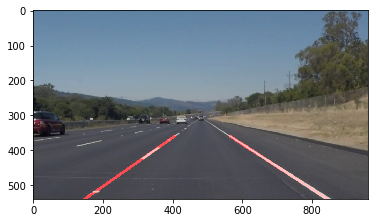

In [5]:
def main_pipeline(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Smooth it a bit with Gaussian Blur
    kernel_size = 5
    sigma = 0
    blurred_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)
    
    # Add in the canny edge detection
    low_threshold = 100
    high_threshold = 200
    edges = cv2.Canny(blurred_gray, low_threshold, high_threshold)
    
    # Use polygon mask to extract region of interest
    imshape = img.shape
    r_coor = np.array([imshape[0], 330, 330, imshape[0]])
    c_coor = np.array([0, 400, 600, imshape[1]])
    masked_edges = region_of_interest(edges, r_coor, c_coor)
    
    # Use morphological operation to clean outliers
    cleaned_edges = morphology.remove_small_objects(masked_edges.astype('bool'), min_size=10, connectivity=2)
    
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 # minimum number of pixels making up a line
    max_line_gap = 20 # maximum gap between pixels to still form a line.
    
    # Use hough transform to detect lines
    line_img= hough_lines(cleaned_edges, threshold, min_line_len, max_line_gap)
    line_last= weighted_img(line_img, img, α=0.8, β=1., γ=0.)
    
    return line_last

line_last = main_pipeline(image)
plt.imshow(line_last)

## Test on video

In [6]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▏         | 3/221 [00:00<00:07, 28.97it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 8.42 s, sys: 2.75 s, total: 11.2 s
Wall time: 11 s
